In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb

from sklearn.datasets import load_breast_cancer
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [2]:
GOAL = ['target']
FEATURES = ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
           'mean smoothness', 'mean compactness', 'mean concavity',
           'mean concave points', 'mean symmetry', 'mean fractal dimension',
           'radius error', 'texture error', 'perimeter error', 'area error',
           'smoothness error', 'compactness error', 'concavity error',
           'concave points error', 'symmetry error', 'fractal dimension error',
           'worst radius', 'worst texture', 'worst perimeter', 'worst area',
           'worst smoothness', 'worst compactness', 'worst concavity',
           'worst concave points', 'worst symmetry', 'worst fractal dimension'
           ]
IGNORED_FEATURES = [] # a placeholder for irrelevant features
TRAIN_FEATURES = list(set([c for c in FEATURES if c not in IGNORED_FEATURES]))
CATEGORICAL_FEATURES = [] # features that require pre-processing

over_sampling = False

In [3]:
def run_load_data():
    print ('load_data - START')
    breast_cancer = load_breast_cancer()
    data = pd.DataFrame(data= np.c_[breast_cancer['data'], \
                                     breast_cancer['target']],
                        columns= ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
                               'mean smoothness', 'mean compactness', 'mean concavity',
                               'mean concave points', 'mean symmetry', 'mean fractal dimension',
                               'radius error', 'texture error', 'perimeter error', 'area error',
                               'smoothness error', 'compactness error', 'concavity error',
                               'concave points error', 'symmetry error', 'fractal dimension error',
                               'worst radius', 'worst texture', 'worst perimeter', 'worst area',
                               'worst smoothness', 'worst compactness', 'worst concavity',
                               'worst concave points', 'worst symmetry', 'worst fractal dimension', 
                                'target'] 
                        )
    
    print ('load_data - END')
    return data

In [4]:
def run_train_test_split(data):
    print ('train_test_split - START')
    train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
    print ('train_test_split - END')
    return train_df, test_df

In [5]:
def run_pre_processing(train_df, test_df):
    print ('pre_processing - START')  
    # TODO: Fill NULL with Mean / Median / -1
    
    # Pre-processing non-numeric values using numeric encoding
    # Why use numeric encoding over one hot encoding:
    # https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931
    for f in CATEGORICAL_FEATURES:
        lbl = LabelEncoder()
        lbl.fit(list(train_df[f].values) + list(test_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))
    print ('pre_processing - END') 
    return train_df, test_df

In [6]:
def run_x_y_split(train_df, test_df):
    print ('x_y_split - START')
    X_train = train_df[TRAIN_FEATURES]
    y_train = train_df[GOAL]
    X_test = test_df[TRAIN_FEATURES]
    y_test = test_df[GOAL]
    print ('x_y_split - END')
    return X_train, y_train, X_test, y_test

In [7]:
def run_over_sampling(X_train, y_train):
    print ('over_sampling - START')
#     TODO: Figure how to oversample using SMOTE 
#     X_train, y_train = SMOTE().fit_sample(X_train, y_train)
#     X_train, y_train = RandomOverSampler().fit_sample(X_train, y_train)
    print ('over_sampling - END')
    return X_train, y_train

In [8]:
def run_grid_search(X_train, y_train):
    print ('grid_search - START')
    dmatrix = xgb.DMatrix(data=X_train, label=y_train)
    gbm_param_grid = {
        'learning_rate': [0.1, 0.01],
        'max_depth': [2, 3],
        'n_estimators': [50],
        'gamma': [2, 5],
        'colsample_bytree': [0.3, 0.7],
        'colsample_bylevel': [0.3, 0.7]
    }
    gbm = xgb.XGBClassifier()
    
    # Perform grid search
    grid = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                            scoring='roc_auc', cv=5, verbose=1)
    grid.fit(X_train, y_train)

    # Print the best parameters & metric
    print("Best parameters found: ", grid.best_params_)
    print("Best AUC found: ", grid.best_score_)

    best_learning_rate = grid.best_params_["learning_rate"]
    best_max_depth = grid.best_params_["max_depth"]
    best_n_estimators = grid.best_params_["n_estimators"]    
    best_gamma = grid.best_params_["gamma"]   
    best_colsample_bytree = grid.best_params_["colsample_bytree"] 
    best_colsample_bylevel = grid.best_params_["colsample_bylevel"]     
    
    print ('grid_search - END')    
    return best_learning_rate, best_max_depth, best_n_estimators, best_gamma, best_colsample_bytree, best_colsample_bylevel

In [26]:
def run_cross_validation(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_gamma, best_colsample_bytree, best_colsample_bylevel):
    print ('cross_validation - START')
    dmatrix = xgb.DMatrix(data=X_train, label=y_train)
    params = {"objective":"binary:logistic", 
              "learning_rate":best_learning_rate,
              "max_depth":best_max_depth,
              "n_estimators":best_n_estimators,
              "gamma":best_gamma,
              "colsample_bytree":best_colsample_bytree,
              "colsample_bylevel":best_colsample_bylevel
             }
    
    cv_results = xgb.cv(dtrain=dmatrix,
                        params=params,
                        nfold=5,
                        num_boost_round=10,
                        metrics="auc",
                        as_pandas=True,
                        seed=123)
    print(cv_results)
    model_evaluation_metric = cv_results["test-auc-mean"].iloc[-1]
    print "cross-validation model accuracy on train dataset: ", model_evaluation_metric
    print ('cross_validation - END')    

In [10]:
def run_train_model(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_gamma, best_colsample_bytree, best_colsample_bylevel):
    print ('train_model - START')    
    model = xgb.XGBClassifier(objective='binary:logistic',
                              learning_rate=best_learning_rate,
                              max_depth=best_max_depth,
                              n_estimators=best_n_estimators,
                              gamma=best_gamma,
                              colsample_bytree=best_colsample_bytree,
                              colsample_bylevel=best_colsample_bylevel,
                              silent=True,
                              seed=123
                             )
    
    model.fit(X_train, y_train)
    print ('train_model - END')   
    return model

In [11]:
def run_prediction(model, X_test):
    print ('run_prediction - START')  
    prediction = model.predict(data=X_test)
    print ('run_prediction - END')  
    return prediction

In [24]:
def run_model_evaluation_on_test(prediction, y_test):
    print ('model_evaluation_on_test - START') 
    prediction = pd.DataFrame(data = prediction, index=y_test.index, columns = ['target'])
    model_evaluation_metric = accuracy_score(y_test, prediction)
    print "model accuracy on test dataset: ", model_evaluation_metric
    print ('model_evaluation_on_test - END') 

In [13]:
def run_feature_importance(model):
    print ('feature_importance - START') 
    xgb.plot_importance(booster=model)
    plt.title('Feature Importance')
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    print ('feature_importance - END')   

load_data - START
load_data - END
train_test_split - START
train_test_split - END
pre_processing - START
pre_processing - END
x_y_split - START
x_y_split - END
grid_search - START
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    7.2s finished


('Best parameters found: ', {'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 3, 'gamma': 2})
('Best AUC found: ', 0.99108118314908111)
grid_search - END
cross_validation - START
   test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0       0.958324      0.022606        0.979956       0.007685
1       0.966253      0.018805        0.988278       0.003937
2       0.970195      0.020104        0.990995       0.003789
3       0.971355      0.020751        0.991378       0.003442
4       0.973570      0.021458        0.992509       0.002997
5       0.973845      0.020989        0.992885       0.002651
6       0.973614      0.021561        0.993013       0.002430
7       0.976208      0.022294        0.994394       0.001978
8       0.976209      0.022679        0.994716       0.002181
9       0.978444      0.018991        0.995021       0.002238
cross-validation model accuracy on train dataset:  0.9784442
cross_validation - EN

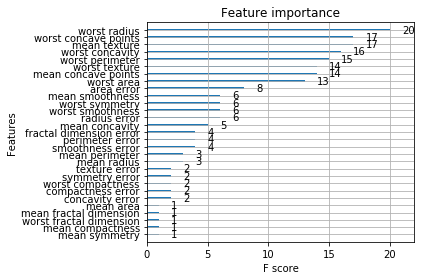

feature_importance - END


In [27]:
def xgboost_binary_classification():
    data = run_load_data()
    train_df, test_df = run_train_test_split(data) # Don't have to run this if you given data is already splitted into train & test
    train_df, test_df = run_pre_processing(train_df, test_df)
    X_train, y_train, X_test, y_test = run_x_y_split(train_df, test_df)
    if over_sampling:
        X_train, y_train = run_over_sampling(X_train, y_train)
    best_learning_rate, best_max_depth, best_n_estimators, best_gamma, best_colsample_bytree,  best_colsample_bylevel = run_grid_search(X_train, y_train)
    run_cross_validation(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_gamma, best_colsample_bytree, best_colsample_bylevel)
    model = run_train_model(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_gamma, best_colsample_bytree, best_colsample_bylevel)
    prediction = run_prediction(model, X_test)
    run_model_evaluation_on_test(prediction, y_test)
    run_feature_importance(model)
xgboost_binary_classification()